In [2]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [82]:
# build the dataset
from numpy import block


block_size = 3
X, Y = [],[]
for w in words:
    #print (w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
    

In [83]:
X.shape, X.dtype, Y.shape, Y.dtype 

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [242]:
# build the dataset
def build_dataset(words):
    block_size = 3
    X, Y = [],[]
    for w in words:
        #print (w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
        #print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [ ]:
X

In [8]:
Y

tensor([ 4, 12, 12,  0,  0, 14, 11,  8, 21,  8,  0,  0,  0, 21,  0,  0,  8, 18,
         0,  1,  4, 11, 11,  0,  0, 18, 14, 15,  7,  8,  0,  0])

In [9]:
C = torch.randn((27, 2))

In [10]:
C[5]

tensor([ 0.1869, -1.2039])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.1869, -1.2039])

In [12]:
C[5]

tensor([ 0.1869, -1.2039])

In [13]:
C[X].shape

torch.Size([32, 3, 2])

In [14]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [15]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [16]:
h = emb.view(emb.shape[0], 6) @ W1 + b1 # emb.view(-1, 6) also works; broadcasting happens with b1
h = torch.tanh(h)

In [17]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [18]:
logits = h @ W2 + b2 

In [19]:
logits.shape

torch.Size([32, 27])

In [20]:
counts = logits.exp()

In [21]:
prob = counts / counts.sum(1, keepdim=True)

In [22]:
prob.shape

torch.Size([32, 27])

In [23]:
prob[0].sum()

tensor(1.0000)

In [24]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [25]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.3372)

In [ ]:
# Now made respectable 

In [ ]:
Xtr.shape, Ytr.shape 

(torch.Size([32, 3]), torch.Size([32]))

In [297]:
g = torch.Generator().manual_seed(2147482647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [298]:
sum(p.nelement() for p in parameters)

11897

In [299]:
for p in parameters:
    p.requires_grad = True

In [300]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [301]:
lri = []
lossi = []
stepi = []


In [302]:

for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters: 
        p.data += -lr * p.grad
    # track status
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

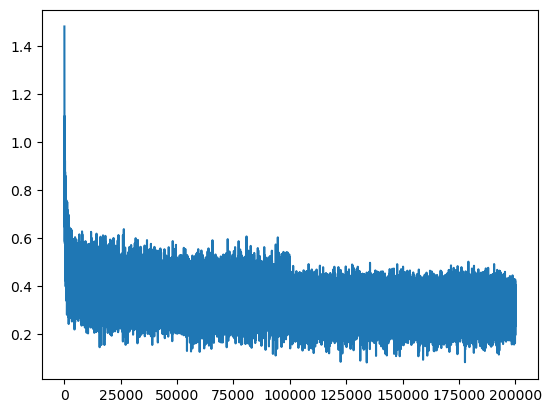

In [303]:
plt.plot(stepi, lossi)

In [304]:
print(loss.item())

2.1760966777801514


In [305]:
# plt.plot(lri, lossi)

In [306]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0757, grad_fn=<NllLossBackward0>)

In [307]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1168, grad_fn=<NllLossBackward0>)

KeyError: 26

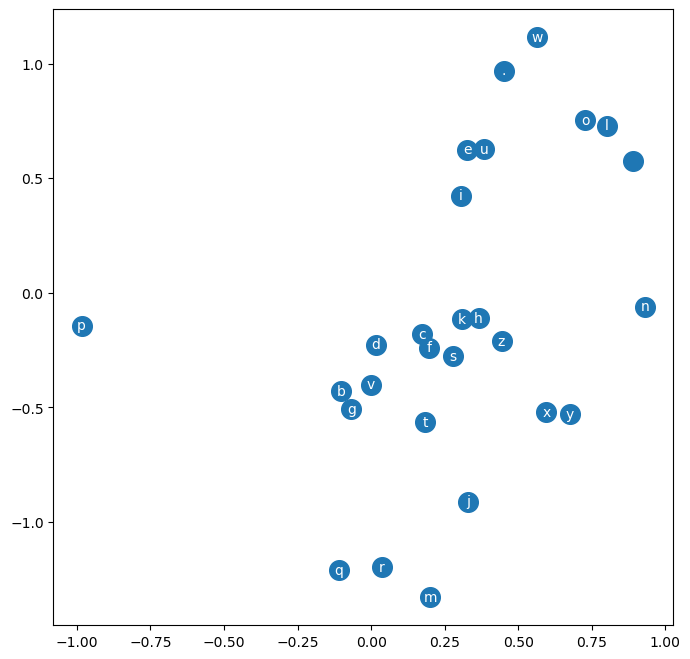

In [294]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va = "center", color='white')
plt.grid('minor')

In [89]:
torch.randint(0, X.shape[0], (32,))

tensor([ 83973, 216458,  66905, 132193, 186715,  70029,  86944, 114302,  27560,
         82974, 142103, 219332, 219072, 131174, 185199, 142445,    833,  39581,
        188790, 206786,  95033,  51692,  70220, 134227,  16471,   8917,  23506,
          5962, 196110, 181764,  30292, 154928])

In [80]:
logits.max(1)

torch.return_types.max(
values=tensor([10.1114, 14.6672, 16.2265, 18.3295, 18.9929, 10.1114, 16.2557, 15.9538,
        15.0560, 13.5766, 20.9566, 21.9336, 10.1114, 10.1114, 15.1607, 20.4156,
        10.1114, 17.9376, 16.6524, 13.3889, 16.9159, 16.4163, 17.6753, 17.4359,
        19.6779, 10.1114, 17.0898, 15.7826, 14.5443, 16.2305, 16.2835, 18.5081],
       grad_fn=<MaxBackward0>),
indices=tensor([18, 12, 12,  0,  0, 18, 11,  8, 21,  8,  0,  0, 18, 18,  0,  0, 18, 18,
         0,  1,  4, 11, 11,  0,  0, 18, 14, 15,  7,  8,  0,  0]))

In [81]:
Y


tensor([ 4, 12, 12,  0,  0, 14, 11,  8, 21,  8,  0,  0,  0, 21,  0,  0,  8, 18,
         0,  1,  4, 11, 11,  0,  0, 18, 14, 15,  7,  8,  0,  0])

In [26]:
h.shape

torch.Size([32, 100])

In [ ]:
emb.view(32, 6)

In [ ]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

In [29]:
torch.cat([emb[:,0, :], emb[:,1, :], emb[:, 2, :]], 1).shape # not efficient as view() because new memory is created

torch.Size([32, 6])

In [30]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [31]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [32]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [33]:
a.storage()

/var/folders/ht/yr0wm26s27ldzwlt34j_zrkh0000gn/T/ipykernel_98377/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]